In [4]:
%matplotlib inline
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [6]:
train = np.loadtxt('../002/data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('../002/data/digit/test.csv', delimiter=',', skiprows=1)

In [7]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

## Визуализируем исходные данные

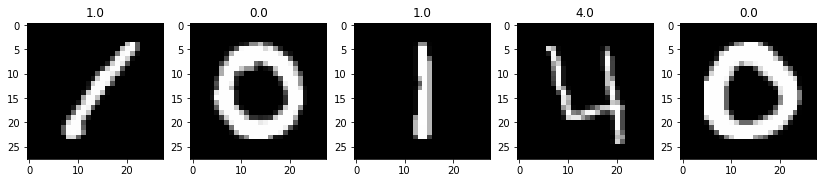

In [8]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [9]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [10]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

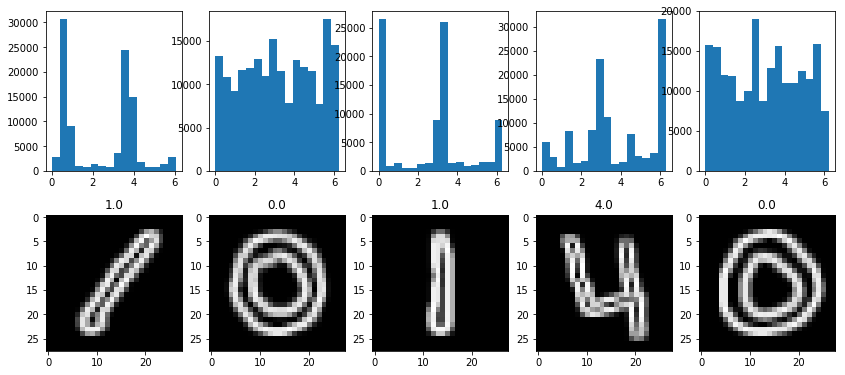

In [11]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [12]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist
    
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [13]:
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [14]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2, random_state=42)

## Собираем полносвязную сеть для обучения

In [15]:
model = keras.models.Sequential()

model.add(keras.layers.Dense(32,
                             input_dim=x_train.shape[1],
                             activation='relu'))

model.add(keras.layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

W0713 20:18:16.602325  3772 deprecation_wrapper.py:119] From d:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0713 20:18:16.627926  3772 deprecation_wrapper.py:119] From d:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0713 20:18:16.630926  3772 deprecation_wrapper.py:119] From d:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0713 20:18:16.655928  3772 deprecation_wrapper.py:119] From d:\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0713 20:18:16.670928  3772 deprecation_wrapper.py:119] From d:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:

## Выводим информацию о модели

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 874
Trainable params: 874
Non-trainable params: 0
_________________________________________________________________


## One hot encoding разметки

In [17]:
y_train.shape

(33600,)

In [18]:
from keras.utils import np_utils
y_train_labels = np_utils.to_categorical(y_train)

## Запускаем обучение

In [19]:
model.fit(x_train, y_train_labels, 
          batch_size=32, validation_split=0.2,
          epochs=10)

W0713 20:18:52.446830  3772 deprecation.py:323] From d:\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0713 20:18:52.543832  3772 deprecation_wrapper.py:119] From d:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 26880 samples, validate on 6720 samples
Epoch 1/10
26880/26880 [==============================] - 1s 22us/step - loss: 1.8033 - acc: 0.3698 - val_loss: 1.4922 - val_acc: 0.4696
Epoch 2/10
26880/26880 [==============================] - 0s 17us/step - loss: 1.3917 - acc: 0.5115 - val_loss: 1.3321 - val_acc: 0.5311
Epoch 3/10
26880/26880 [==============================] - 0s 18us/step - loss: 1.2819 - acc: 0.5536 - val_loss: 1.2551 - val_acc: 0.5667
Epoch 4/10
26880/26880 [==============================] - 0s 18us/step - loss: 1.2249 - acc: 0.5698 - val_loss: 1.2090 - val_acc: 0.5774
Epoch 5/10
26880/26880 [==============================] - 0s 18us/step - loss: 1.1913 - acc: 0.5801 - val_loss: 1.1845 - val_acc: 0.5768
Epoch 6/10
26880/26880 [==============================] - 0s 18us/step - loss: 1.1689 - acc: 0.5844 - val_loss: 1.1700 - val_acc: 0.5804
Epoch 7/10
26880/26880 [==============================] - 0s 18us/step - loss: 1.1539 - acc: 0.5883 - val_loss: 1.1499 - val_acc:

## Предсказываем класс объекта

In [20]:
from sklearn.linear_model import LogisticRegression

In [21]:
pred_val = model.predict_classes(x_val)

In [22]:
pred_proba = model.predict_proba(x_val)

## Оцениваем качество решение на валидационной выборке

In [23]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.595


In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

         0.0       0.36      0.28      0.31       816
         1.0       0.95      0.95      0.95       909
         2.0       0.43      0.34      0.38       846
         3.0       0.59      0.74      0.65       937
         4.0       0.64      0.65      0.65       839
         5.0       0.59      0.57      0.58       702
         6.0       0.40      0.43      0.42       785
         7.0       0.83      0.74      0.78       893
         8.0       0.48      0.55      0.51       835
         9.0       0.58      0.62      0.60       838

   micro avg       0.59      0.59      0.59      8400
   macro avg       0.59      0.59      0.58      8400
weighted avg       0.59      0.59      0.59      8400



In [25]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[227   8  68  35  42  24 181   3 180  48]
 [  3 867   3   0  24   0   3   3   0   6]
 [ 52   0 288 190   5 126  50  28  86  21]
 [ 24   0  67 692   0  63   4   4  68  15]
 [ 15  26  10   2 542   0 109  26   7 102]
 [  5   0  79 144   0 401  10   8  50   5]
 [127   3  59  16  86   8 337   9  79  61]
 [  4   7  35   7  58  11  36 660   5  70]
 [129   0  25  76   7  37  41   6 462  52]
 [ 41   4  31  17  77   4  62  48  32 522]]


## Предсказания на тестовыйх данных

In [26]:
pred_test = model.predict_classes(test_hist)

## Визуализируем предсказания

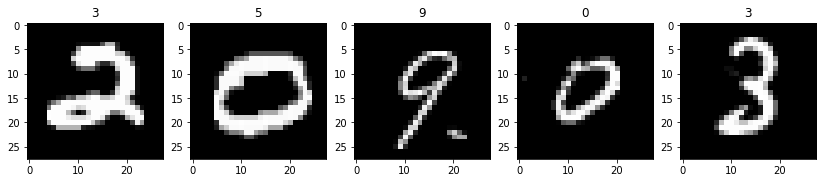

In [27]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [28]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [ ]:
# Your submission scored 0.59843